## <center>Assignment 4: Text Classification </center>

You'll need two data files:
- training data file: `hw4_train.csv`
- test data file: `hw4_test.csv`

The data file contains a text column and a label column to indicate the sentiment of the text (0: negative, 1: positive). A few samples from the dataset is shown below.

`Note, for analysis part, you can submit a pdf file to document your analysis`

In [4]:
train = pd.read_csv("hw4_train.csv")
train.head()

,text,label
0,This product worked for 4-5 times and the rota...,0
1,I was a fan of Destiny's Child when the origin...,0
2,I bought this since the big MK I also use was ...,1
3,This product did not work in my case. It did N...,0
4,In this movie we see Malon Brando as an ageing...,1


### Task 1: Naive Bayes Model

- Define a function `nb_model(train_docs, train_y, test_docs, test_y, stop_words='english', binary=False, use_idf=True)`, where
    - `train_docs`: is a list of documents for training
    - `train_y`: is the ground-truth labels of training documents
    - `test_docs`: is a list of documents for test 
    - `test_y`: is the ground-truth labels of test documents
    - `stop_words`: indicate whether stop words should be removed from features. The default value is 'english', i.e. all English stop words are removed.
    - `binary`: whether to use binary values (1: present and 0: not present) for term frequency (tf). The default value is False (do not use binary tf)
    - `use_idf`: wheter idf (inverse document frequency) is used. If not used, only the tf (term frequency) is used as features. The default value is True, i.e. TF-IDF is used as features.

- This function does the following:
    - Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, binary, use_idf` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
    - Train `MultinomialNB` model using the extracted features and `train_y`
    - Tranform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`)
    - Predict the labels for `test_docs` and print the classification report
    - Print the AUC score for class 1 and plot the ROC curve
    - Print the PRC score (or Average Precision) for class 1 and plot the PRC curve
    - Return the fitted model and fitted `TfidfVectorizer`

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from matplotlib import pyplot as plt

In [5]:
def nb_model(train_docs, train_y, test_docs, test_y,binary=False, stop_words='english', use_idf=True):

    tfidf_vect = TfidfVectorizer(binary=binary, stop_words=stop_words, use_idf=use_idf)
    dtm = tfidf_vect.fit_transform(train_docs)     # tfidf matrix for train_docs
    # print(dtm.shape)

    dtm_new = tfidf_vect.transform(test_docs)   # new tfidf matrix for test_docs
    # print(dtm_new.shape)

    clf = MultinomialNB().fit(dtm, train_y) #  model
    predicted=clf.predict(dtm_new)

    labels=sorted(train["label"].unique())
    # print(labels)
    print('Classification Report:\n',classification_report(test_y, predicted))    # classification_report

    predict_proba=clf.predict_proba(dtm_new)
    # print(predict_proba[:3])
    # print(test_y[:3])
    binary_y = np.where(test_y==1,1,0)   # ground truth
    y_pred = predict_proba[:,1]     #  second label, label 1
    fpr, tpr, thresholds = roc_curve(binary_y, y_pred, pos_label=1)
    print("AUC: {:.2%}".format(auc(fpr, tpr)))

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC of Naive Bayes Model')
    plt.show()

    precision, recall, thresholds = precision_recall_curve(binary_y, y_pred, pos_label=1)
    print("PRC: {:.2%}".format(auc(recall, precision)))

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision_Recall_Curve of Naive Bayes Model')
    plt.show()
    
    return clf, tfidf_vect

In [6]:
train = pd.read_csv("hw4_train.csv")
test = pd.read_csv("hw4_test.csv")

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77       235
           1       0.79      0.83      0.81       265

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500

AUC: 87.57%


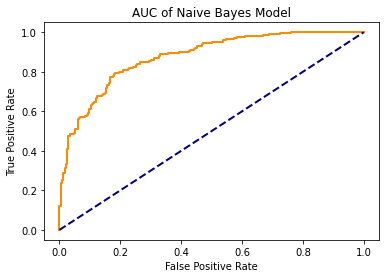

PRC: 88.74%


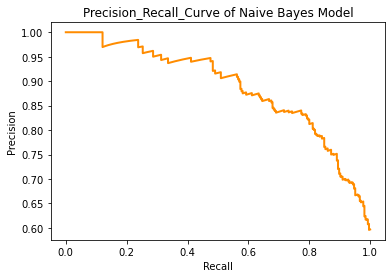

In [7]:
model, tfidf_vect = nb_model(train["text"], train["label"], test["text"], test["label"])

### Task 2: Search for best parameters

- Define a function `search_para(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and `MultinomialNB` 
    - Define the parameter ranges as follow:
        - `use_idf: [True, False]`,
        - `binary: [True, False]`,
        - `stop_words': [None, 'english']`
    - Use `GridSearchCV` with 5-fold cross validation to find the best parameter values based on the training dataset. 
    - Print the best parameter values
- Call the function `nb_model` defined in Task 1 `with the best parameter values`. Please briefly answer the following:
    - Compare with the model in Task 1, how is the performance improved?
    - Why do you think the new configuration of `TfidfVectorizer` help sentiment classification?

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def search_para(docs, y):
    
    pipeline  = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])
    parameters = {'tfidf__use_idf':[True,False], 'tfidf__binary':[True, False], 'tfidf__stop_words':[None,'english']}
    
    metric =  "f1_macro"
    gs_clf = GridSearchCV(pipeline, param_grid=parameters, scoring=metric, cv=5)
    
    gs_clf = gs_clf.fit(docs, y)
    
    for param_name in gs_clf.best_params_:
        print("{0}:\t{1}".format(param_name,gs_clf.best_params_[param_name]))
    print("best f1 score: {:.3f}".format(gs_clf.best_score_))

In [9]:
search_para(train["text"], train["label"])

tfidf__binary:	True
tfidf__stop_words:	None
tfidf__use_idf:	False
best f1 score: 0.824


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       235
           1       0.83      0.82      0.82       265

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500

AUC: 89.10%


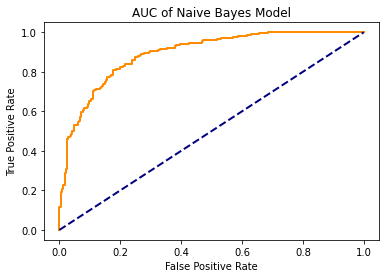

PRC: 89.55%


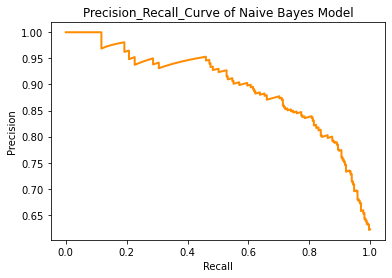

In [10]:
# Call the function with the best parameter values

model, tfidf_vect = nb_model(train["text"], train["label"], test["text"], test["label"],\
        binary = True,stop_words = None, use_idf = False)

### Task 3: Find the best K in K-fold cross validation

- Define a function `k_fold(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Fit `TfidfVectorizer` using `docs`. In this task, it is not necessary to tune the parameters of `TfidfVectorizer`. You can just use the default options. 
    - Loop through `k` from 2 to 20. For each `k` value:
        - Fit a `linear SVM model` using `k-fold` cross validation
        - Record the mean F1-Macro score over `k` folds
    - Print a line chart with `k` as X axis and the mean F1-Macro score as Y axis
- With this plot, analyze:
    - How performance changes as `k` increases? 
    - Why the performance changes in this way?
    - What can the appropriate `k` value if you perform `k-fold` cross validation on this dataset?

In [37]:
from sklearn import svm
from sklearn.model_selection import cross_validate

def k_fold(docs, y):
    
    tfidf_vect = TfidfVectorizer()
    dtm = tfidf_vect.fit_transform(docs) 
    clf = svm.LinearSVC()
    
    k_value, average_fscore = [],[]
    for k in range(2,21):
        metrics = ['precision_macro', 'recall_macro', "f1_macro"]
        cv = cross_validate(clf, dtm, y, scoring=metrics, cv=k)
        average_fscore.append(np.mean(cv['test_f1_macro']))
        k_value.append(k)
    
    plt.plot(k_value, average_fscore, color='darkorange', lw=2)
    plt.xlabel('K-Fold')
    plt.ylabel('F1 Macro')
    plt.title('F1 Marco vs. K-Fold')
    plt.show()     

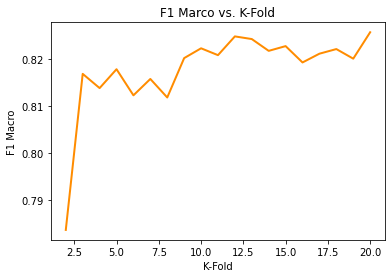

In [38]:
# Call the function
# Note, you may get different chart due to randomness involved in data partition

k_fold(train["text"], train["label"])


### Task 4 (Bonus): Interpret Naive Bayes Model

- Suppose you have a new document:

*"Great American classic that you can get for free on kindle. I was supposed to read this back in high school but wasn't not interested at the time. But now with the benefit of age I can really appreciate it."*

- Predict the label for this document using the fitted model and fitted `TfidfVectorizer` returned from Task 2
- Very likely, this document is predicted to be positive. Could you analyze `why this document is predicted to be positive? What features are highly influential?` Please answer this question based on Naive Bayes algorithm (hint: consider the conditional probability $p(w|c=0), p(w|c=1)$. Also check sklearn package to see how to get this conditional probability)

In [39]:
doc="Great American classic that you can get for free on kindle. I was supposed to read this back in high school but wasn't not interested at the time. But now with the benefit of age I can really appreciate it."
doc

"Great American classic that you can get for free on kindle. I was supposed to read this back in high school but wasn't not interested at the time. But now with the benefit of age I can really appreciate it."

In [ ]:
# Add your code and explanation

def show_analysis(doc, model, tfidf_vect)

    model, tfidf_vect = nb_model(train["text"], train["label"], test["text"], test["label"])
    tfidf_vect_new = tfidf_vect.transform(docs)
    prediction = model.predict(tf_idf_new)
    
    return prediction

### Test: Put everything together

In [ ]:
if __name__ == "__main__":  
    
    train = pd.read_csv("hw4_train.csv")
    test = pd.read_csv("hw4_test.csv")

    print("===== Test Q1 ======")
    
    model, tfidf_vect = nb_model(train["text"], train["label"], \
         test["text"], test["label"])
    
    print("\n")
    
    print("===== Test Q2 ======")
    
    search_para(train["text"], train["label"])
    
    model, tfidf_vect = nb_model(train["text"], train["label"], \
        test["text"], test["label"],\
        binary = True,stop_words = None, \
        use_idf = False)
    
    print("\n")
    
    print("===== Test Q3 ======")
    
    k_fold(train["text"], train["label"])
    
    print("\n")
    
    print("===== Test Q4 ======")
    
    show_analysis(doc, model, tfidf_vect)
    
    print("\n")